In [1]:
import requests
import time
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
def plot_unit_trusts(df, df_lookback, fund_name):
    fig = plt.figure(figsize=(18, 4.5))
    gs = mpl.gridspec.GridSpec(1, 2, width_ratios=[3, 1])    

    ax0 = plt.subplot(gs[0, 0])
    ax0.plot(df.index[df['regular_decrease']], df['price'][df['regular_decrease']], 'ro')
    ax0.plot(df.index, df['price'], color='#3F7BB9', marker='.', ls='-')
    ax0.fill_between(df.index, df['p-std11'], df['p+std11'], facecolor='grey', alpha=0.4)
    ax0.fill_between(df.index, df['p-std31'], df['p+std31'], facecolor='grey', alpha=0.3)
    ax0.set_title(fund_name)
    #ax0.set_xlabel('Date')
    ax0.set_ylabel('Price / [ZAR]')
    ax0.xaxis.grid(True, ls='--')
    ax0.yaxis.grid(True, ls='--')
                      
    ax1 = plt.subplot(gs[0, 1])
    ax1.plot(df_lookback.index[df_lookback['regular_decrease']], df_lookback['price'][df_lookback['regular_decrease']], 'ro')
    ax1.plot(df_lookback.index, df_lookback['price'], color='#3F7BB9', marker='.', ls='-')
    ax1.fill_between(
        df_lookback.index,
        df_lookback['price'] - df_lookback['std'],
        df_lookback['price'] + df_lookback['std'],
        facecolor='grey',
        alpha=0.4)
    #ax1.set_xlabel('Date')
    ax1.xaxis.grid(True, ls='--')
    ax1.yaxis.grid(True, ls='--')
    ax1.xaxis.set_major_locator(
        mpl.dates.WeekdayLocator(byweekday=mpl.dates.MO)
    )
    ax1.xaxis.set_major_formatter(
        mpl.dates.DateFormatter('%d %b\n%Y')
    )
    
    figure_file = 'Coronation_fund_prices_{}.png'.format(end_date)
    plt.savefig('Coronation_fund_prices_{}.png'.format(end_date))
    plt.tight_layout() 


def get_data_and_plot(fund_code_and_name, start_date, end_date):
    CORONATION_FUND_URL = 'www.coronation.com/FundPricesDownload'

    fund, fund_name = fund_code_and_name 
    print('Getting data for fund {}'.format(fund))
    full_req = 'http://{0}/{1}/{2}/{3}'.format(CORONATION_FUND_URL, start_date, end_date, fund)
    resp = requests.get(full_req)

    excel_filename = 'text.xlsx'
    with open(excel_filename, 'wb') as output:
        output.write(resp.content)
    df = pd.read_excel(excel_filename)
    os.remove(excel_filename)

    # figure out what row data starts at by looking at the fund price column
    fund_prices = pd.to_numeric(df.iloc[:, 1], errors='coerce')
    ii = 1

    non_nan_rows = fund_prices.notnull()
    fund_prices = fund_prices[non_nan_rows][::-1]
    dates = pd.to_datetime(df.iloc[:, 0][non_nan_rows])[::-1]

    centre_std_11 = fund_prices.rolling(window=11, center=True).std().fillna(0)
    centre_std_31 = fund_prices.rolling(window=31, center=True).std().fillna(0)

    df_fund = pd.DataFrame({
        'price': fund_prices,
        'date': dates,
        'p+std11': fund_prices+centre_std_11,
        'p-std11': fund_prices-centre_std_11,
        'p+std31': fund_prices+centre_std_31,
        'p-std31': fund_prices-centre_std_31
    })
    df_fund.set_index('date', inplace=True)

    # when should we have bought?
    regular_decrease = np.zeros_like(fund_prices, dtype=np.bool)
    decrease_days = 6
    for i in range(decrease_days, len(fund_prices)):
        regular_decrease[i] = np.all(fund_prices.iloc[i] < fund_prices.iloc[i-decrease_days:i])
    df_fund['regular_decrease'] = regular_decrease
    buy = True if np.any(regular_decrease[-3:]) else False
    
    buy_amount = 100.
    n_low_buys = np.sum(regular_decrease)
    total_buy_amount = buy_amount * n_low_buys
    bought_at_low_price = np.sum(buy_amount/fund_prices[regular_decrease])
    print('Buy low {} times'.format(n_low_buys))
    
    # and if we bought regularly every month?
    monthly_price = df_fund.groupby(pd.TimeGrouper(freq='M'))['price'].first()
    n_months = len(monthly_price)
    spent_per_month = total_buy_amount / n_months
    bought_monthly = np.sum(spent_per_month / monthly_price)
    print('Ratio of low buying to regular buying:', bought_at_low_price/bought_monthly)

    # recent lookback plot
    lookback_days = 30    
    df_lookback = pd.DataFrame({
        'price': fund_prices[-lookback_days:],
        'regular_decrease': regular_decrease[-lookback_days:],
        'date': df_fund.index[-lookback_days:],
        'std': fund_prices.rolling(window=15).std().fillna(0)[-lookback_days:]
    })
    df_lookback.set_index('date', inplace=True)
             
    # plot the results
    plot_unit_trusts(df_fund, df_lookback, fund_name) 

In [3]:
fund_code_and_name = {
    'UTTOP': 'Top20',
    'UTINTG': 'Global Opportunities Equity [ZAR] Feeder',
    'UTCAPP': 'Capital Plus',
    'CIHEMF_USD_RETL': 'Global Emerging Markets',
    'CGESMF': 'Global Equity Select',
    'UTGESF': 'Global Equity Select [ZAR] Feeder',
    'UTSPGR': 'Smaller Companies',
    'UTGEMF': 'Global Emerging Markets Flexible [ZAR]'
}
funds = np.array([list(fund_code_and_name.keys()), list(fund_code_and_name.values())]).T

start_date = '01-01-2016'
now = pd.Timestamp(time.time(), unit='s')
end_date = now.strftime('%d-%m-%Y')

Getting data for fund UTGEMF
Buy low 73 times
Ratio of low buying to regular buying: 1.02138891974


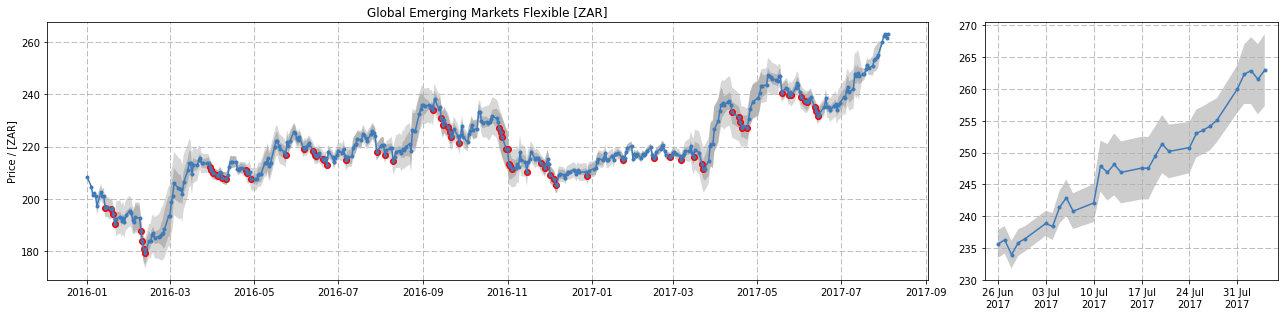

In [4]:
get_data_and_plot(funds[0], start_date, end_date)

Getting data for fund UTGESF
Buy low 75 times
Ratio of low buying to regular buying: 1.02554174592


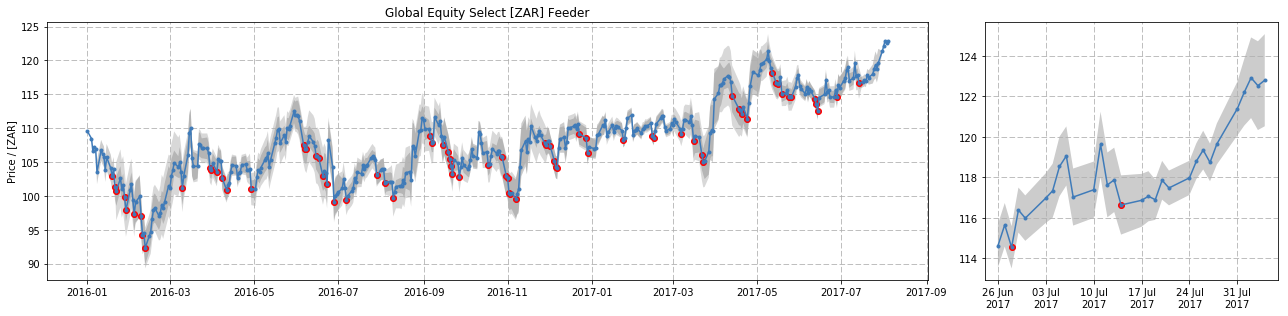

In [5]:
get_data_and_plot(funds[1], start_date, end_date)

Getting data for fund UTINTG
Buy low 83 times
Ratio of low buying to regular buying: 1.0241348393


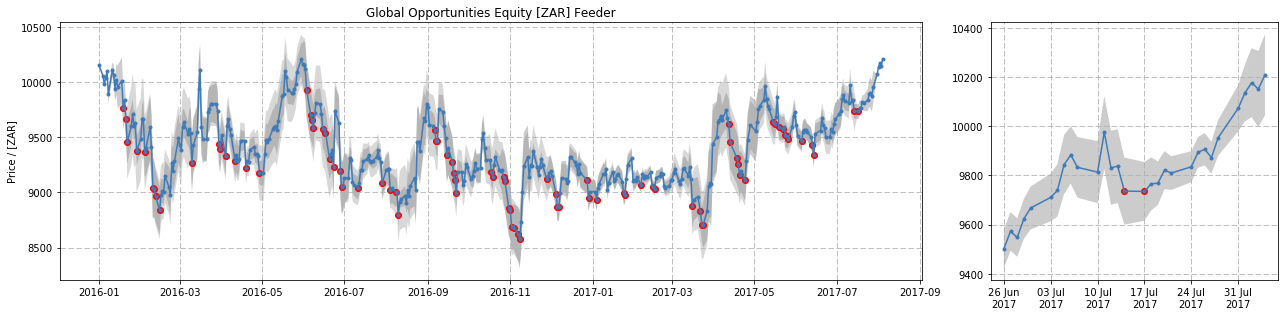

In [6]:
get_data_and_plot(funds[2], start_date, end_date)

Getting data for fund UTSPGR
Buy low 76 times
Ratio of low buying to regular buying: 1.00785352654


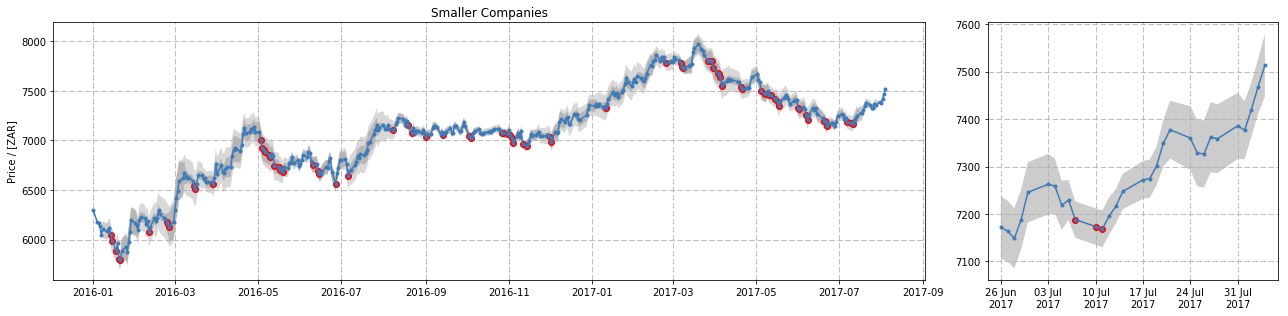

In [7]:
get_data_and_plot(funds[3], start_date, end_date)

Getting data for fund UTTOP
Buy low 72 times
Ratio of low buying to regular buying: 1.02303166417


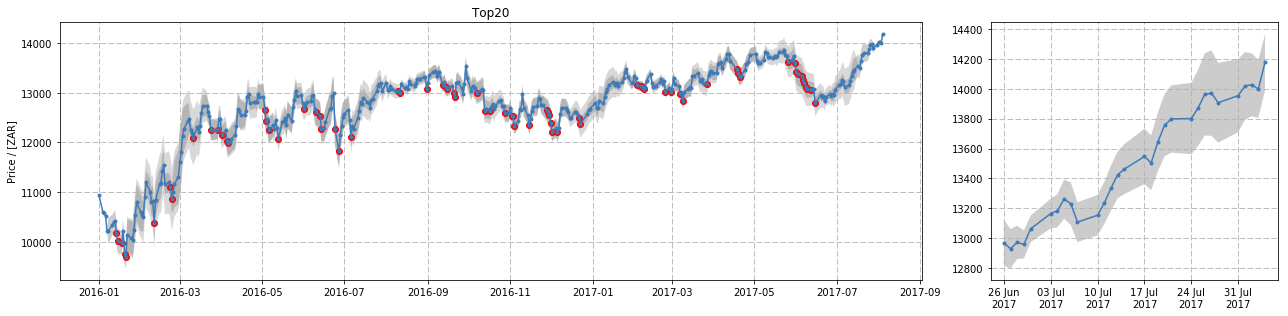

In [8]:
get_data_and_plot(funds[4], start_date, end_date)

Getting data for fund UTCAPP
Buy low 88 times
Ratio of low buying to regular buying: 1.00374104534


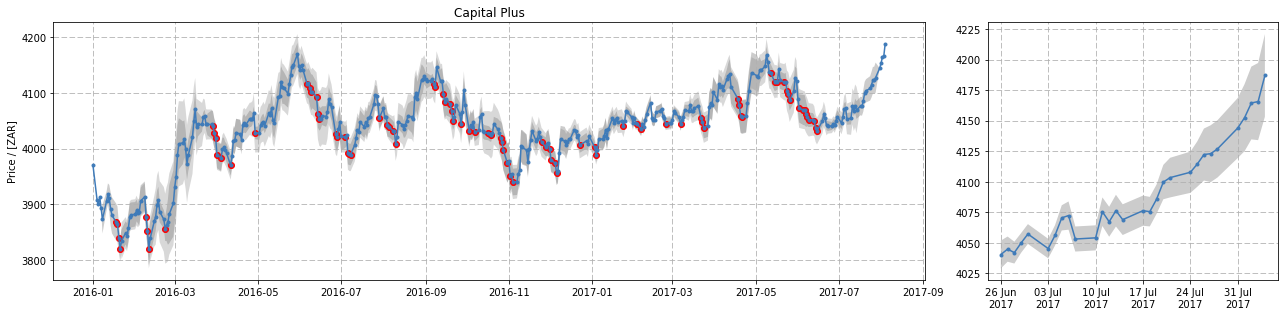

In [9]:
get_data_and_plot(funds[5], start_date, end_date)

Getting data for fund CGESMF
Buy low 61 times
Ratio of low buying to regular buying: 1.03437804663


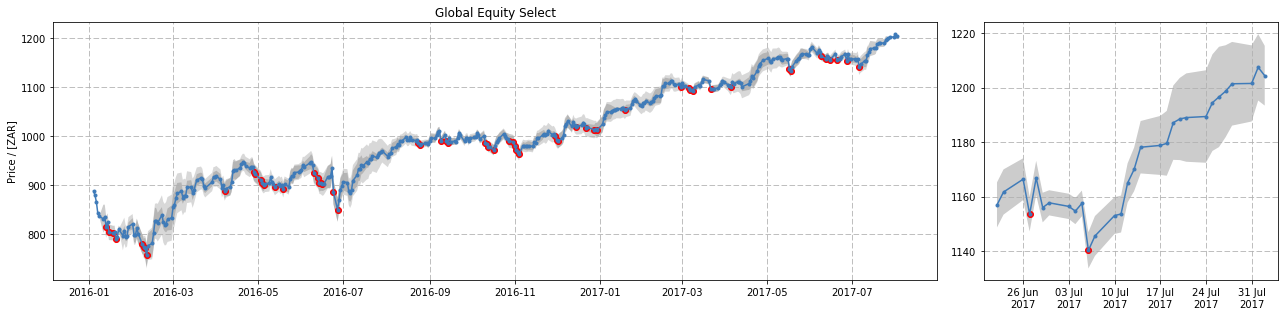

In [10]:
get_data_and_plot(funds[6], start_date, end_date)